In [ ]:
from datasets import load_dataset, Dataset
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
from tqdm import tqdm
from huggingface_hub import login, HfApi

# Explore Data

In [ ]:
dataset = load_dataset('khoadole/cars_dataset_path_30k')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/271M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/58971 [00:00<?, ? examples/s]

In [ ]:
cars_df = dataset['train'].to_pandas()
cols_selected = ["id", "brand", "name", "price", "Exterior color", "image"]
cars_df = cars_df[cols_selected]
display(cars_df.head())
print(cars_df.shape)

,id,brand,name,price,Exterior color,image
0,1,acura,2003 Acura RSX Type S,"$6,000",Silver,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1,1,acura,2003 Acura RSX Type S,"$6,000",Silver,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2,2,acura,2014 Acura RLX Technology Package,"$18,950",Bellanova White Pearl,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3,2,acura,2014 Acura RLX Technology Package,"$18,950",Bellanova White Pearl,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4,3,acura,2014 Acura RLX Advance Package,"$18,999",Forged Silver Metallic,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


(58971, 6)


# Process cars type and colors

In [ ]:
def shorten_name(name):
    # 2003 Acura RSX Type S
    # match = re.match(r"(\d{4} \w+ \w+)", name) # 2003 Acura RSX
    match = re.match(r"^\d{4}\s(\w+\s\w+)", name) # Acura RSX
    return match.group(1) if match else name

cars_df.loc[:, "name"] = cars_df["name"].apply(shorten_name)
cars_df.head()

,id,brand,name,price,Exterior color,image
0,1,acura,Acura RSX,"$6,000",Silver,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1,1,acura,Acura RSX,"$6,000",Silver,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2,2,acura,Acura RLX,"$18,950",Bellanova White Pearl,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3,2,acura,Acura RLX,"$18,950",Bellanova White Pearl,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4,3,acura,Acura RLX,"$18,999",Forged Silver Metallic,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


In [ ]:
main_colors = {
    "white": ["white", "pearl", "chalk", "cream", "snow", "ice", "ivory", "magnolia", "porcelain", "arctica", "artica", "mineral", "wht", "whi"],
    "black": ["black", "onyx", "ebony", "carbon", "phantom", "night", "charcoal", "beluga", "majestic"],
    "gray": ["grey", "graphite", "gray", "anthracite", "stone", "titan", "quantum", "storm", "gry", "granite", "meteor", "pewter", "thunder", "tungsten", "vapor", "daytona"],
    "silver": ["silver", "platinum", "silverstone", "metallic", "lunar", "frost", "titanium", "moon", "moonbeam", "moonlight", "magnetic", "steel", "hallmark"],
    "red": ["red", "burgundy", "maroon", "crimson", "ruby", "garnet"],
    "blue": ["blue", "navy", "azure", "sapphire", "cobalt", "indigo", "breeze", "jetstream", "kingfisher", "marlin", "peacock", "portofino"],
    "green": ["green", "emerald", "olive", "forest", "jade", "cypress", "patina", "teal", "verdant", "viridian"],
    "yellow": ["yellow", "gold", "amber", "lemon", "champagne"],
    "brown": ["brown", "beige", "copper", "tan", "oak", "cinnamon", "arabica", "cricket ball"],
    "orange": ["orange", "bronze", "tangerine", "flame"],
    "purple": ["purple", "tanzanite"]
}

def get_main_color(color):
    color = color.lower()
    for main_color, keywords in main_colors.items():
        if any(re.search(rf"\b{k}\b", color) for k in keywords):
            return main_color
    return "other"

cars_df.loc[:, "Exterior color"] = cars_df["Exterior color"].apply(get_main_color)

In [ ]:
# Drop other color
colors_row_none = cars_df[cars_df["Exterior color"].isin(["other"])].index
cars_df = cars_df.drop(colors_row_none)

# Selected brand
brands = ["audi", "acura", "bmw", "bentley"]
cars_df = cars_df[cars_df["brand"].isin(brands)]
print(cars_df["brand"].value_counts())

brand
audi       20227
acura      18901
bmw        12345
bentley     2427
Name: count, dtype: int64


In [ ]:
cars_short = cars_df.copy()
# Brand Selection
counts = cars_short.name.value_counts()
rare_cars = counts.loc[counts < 100]
cars_short = cars_short[~cars_short.name.isin(rare_cars.index)]

top_types = {}
for brand in brands:
    top_types[brand] = cars_short[cars_short["brand"] == brand]["name"].value_counts().head(4).index.tolist()
cars_short = cars_short[cars_short.apply(lambda row: row["name"] in top_types.get(row["brand"], []), axis=1)]

# Color Selection
top_colors = {}
for brand in brands:
    top_colors[brand] = cars_short[cars_short["brand"] == brand]["Exterior color"].value_counts().head(5).index.tolist()

cars_short = cars_short[cars_short.apply(lambda row: row["Exterior color"] in top_colors.get(row["brand"], []), axis=1)]

In [ ]:
audi_name = cars_short[cars_short["brand"] == "audi"]["name"].value_counts()
acura_name = cars_short[cars_short["brand"] == "acura"]["name"].value_counts()
bmw_name = cars_short[cars_short["brand"] == "bmw"]["name"].value_counts()
bentley_name = cars_short[cars_short["brand"] == "bentley"]["name"].value_counts()

audi_color = cars_short[(cars_short["brand"] == "audi")]["Exterior color"].value_counts()
acura_color = cars_short[(cars_short["brand"] == "acura")]["Exterior color"].value_counts()
bmw_color = cars_short[(cars_short["brand"] == "bmw")]["Exterior color"].value_counts()
bentley_color = cars_short[(cars_short["brand"] == "bentley")]["Exterior color"].value_counts()

In [ ]:
common_colors = cars_short["Exterior color"].value_counts().head(5).index.tolist()
balanced_cars_df = cars_short.groupby("brand").apply(lambda x: x.sample(n=2000, random_state=42) if len(x) > 2000 else x)
cars_short = balanced_cars_df[balanced_cars_df["Exterior color"].isin(common_colors)]

<ipython-input-14-55dd092106bc>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_cars_df = cars_short.groupby("brand").apply(lambda x: x.sample(n=2000, random_state=42) if len(x) > 2000 else x)


# First EDA

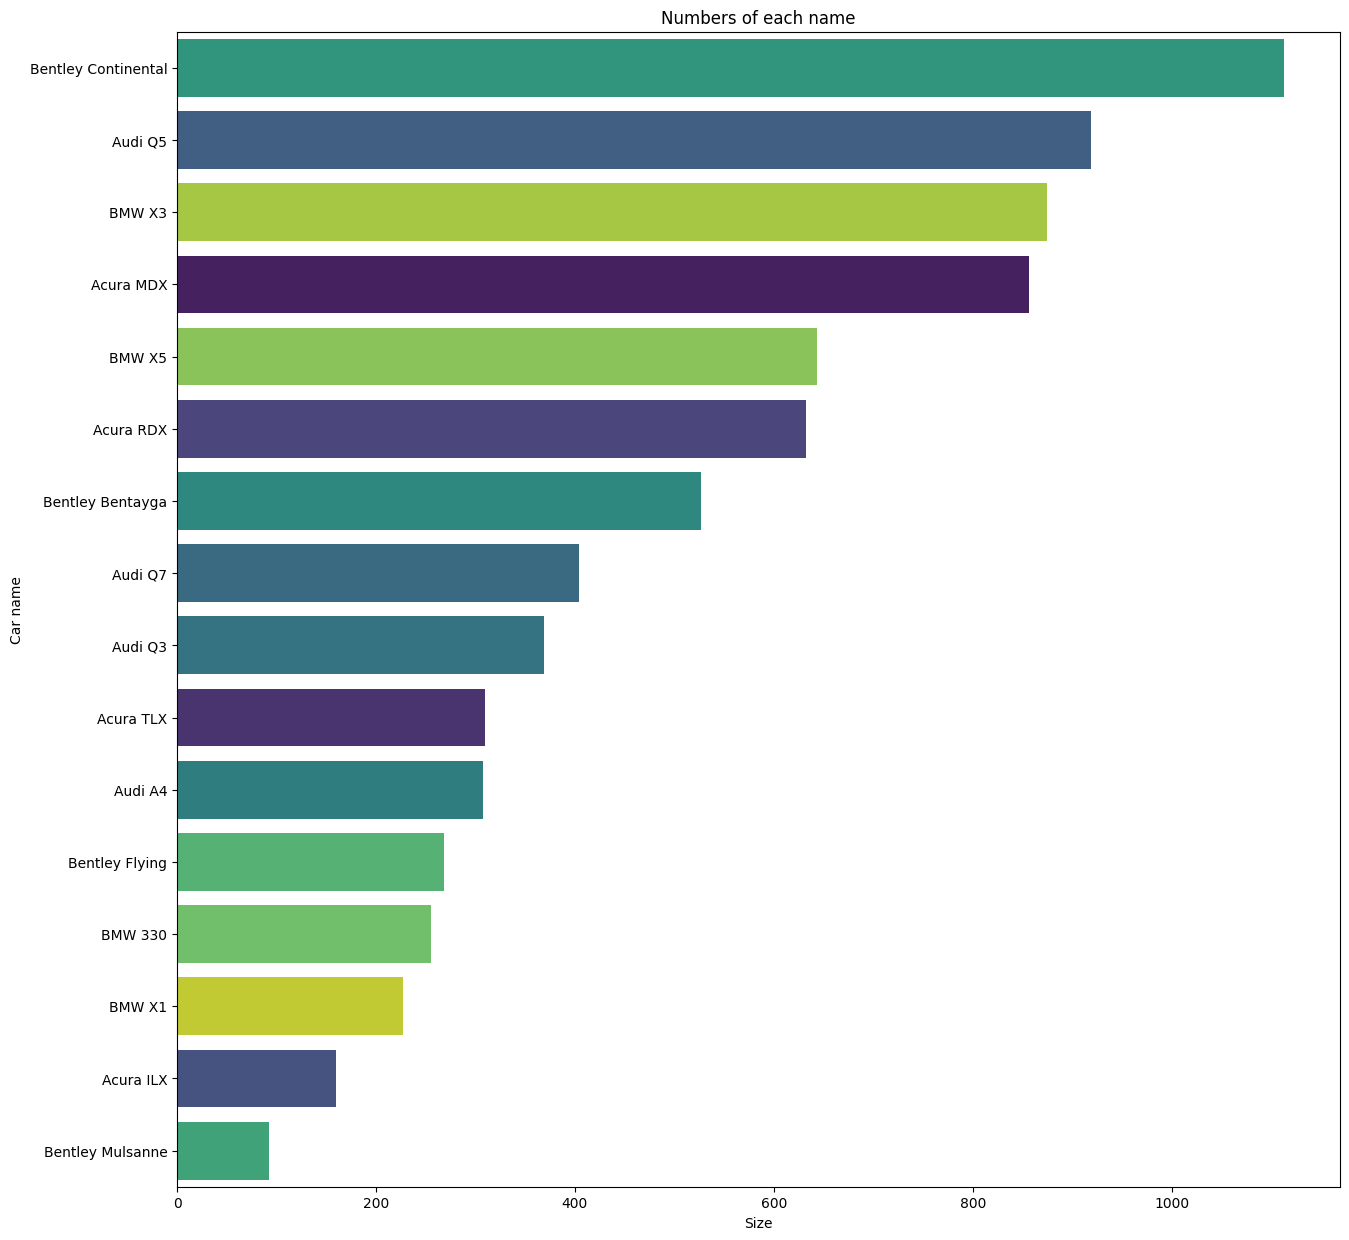

In [ ]:
plt.figure(figsize=(15, 15))
sns.countplot(y=cars_short["name"], hue=cars_short["name"], order=cars_short["name"].value_counts().index, palette="viridis", legend=False)
plt.title("Numbers of each name")
plt.xlabel("Size")
plt.ylabel("Car name")
plt.show()

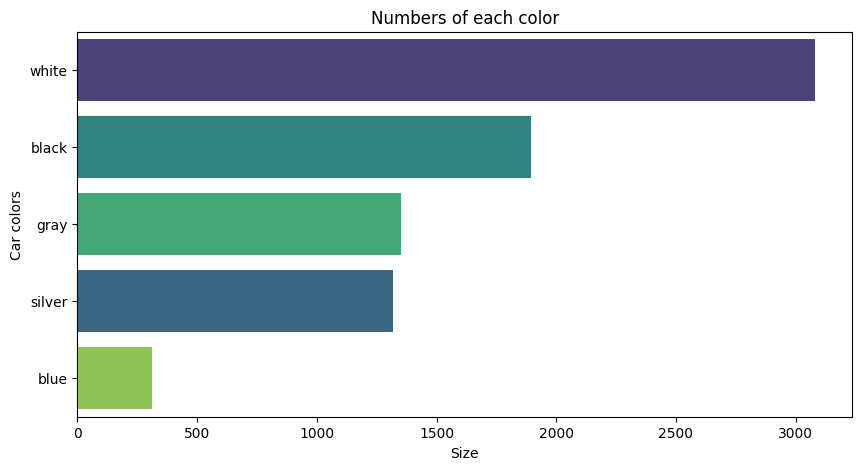

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(y=cars_short["Exterior color"], hue=cars_short["Exterior color"], order=cars_short["Exterior color"].value_counts().index, palette="viridis", legend=False)
plt.title("Numbers of each color")
plt.xlabel("Size")
plt.ylabel("Car colors")
plt.show()

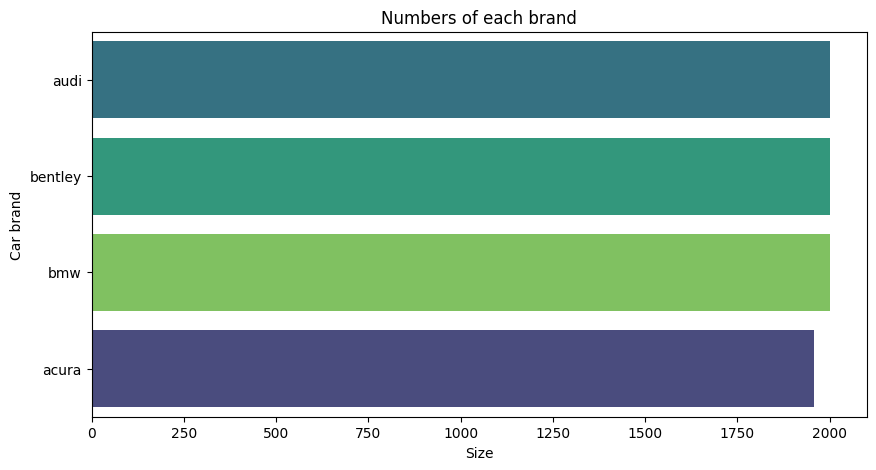

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(y=cars_short["brand"], hue=cars_short["brand"], order=cars_short["brand"].value_counts().index, palette="viridis", legend=False)
plt.title("Numbers of each brand")
plt.xlabel("Size")
plt.ylabel("Car brand")
plt.show()

# Upload to Hugging Face

In [ ]:
def upload_to_huggingface(dataset_df, dataset_name, token):
    login(token=token)
    api = HfApi()

    # Convert pandas DataFrames to Hugging Face Dataset objects
    dataset = Dataset.from_pandas(dataset_df)
    # validation_dataset = Dataset.from_pandas(validation_df)
    # test_dataset = Dataset.from_pandas(test_df)

    # Create a DatasetDict with the three splits
    # from datasets import DatasetDict
    # dataset_dict = DatasetDict({
        # 'train': train_dataset,
        # 'validation': validation_dataset,
        # 'test': test_dataset,
    # })

    dataset.push_to_hub(dataset_name)

    print(f"Dataset uploaded successfully to {dataset_name}")
    print(f"Access your dataset at: https://huggingface.co/datasets/{dataset_name}")

dataset_name = "khoadole/cars_8k_balance_dataset"
token = "YOUR_HF_TOKEN"
upload_to_huggingface(cars_short, dataset_name, token)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/80 [00:00<?, ?ba/s]

Dataset uploaded successfully to khoadole/cars_8k_balance_dataset
Access your dataset at: https://huggingface.co/datasets/khoadole/cars_8k_balance_dataset
